Generating Zoom 2008...


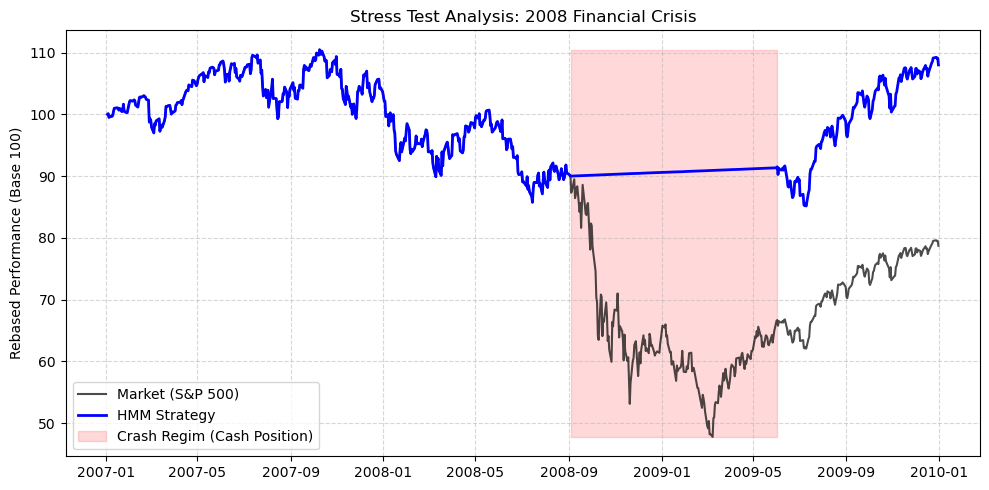

Chart saved: zoom_2008.png
Generating Zoom 2020...


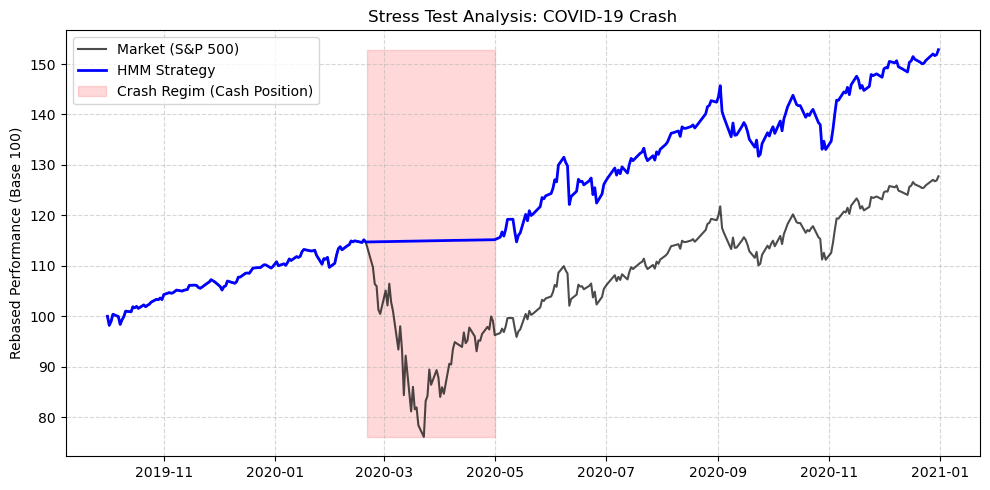

Chart saved: zoom_2020.png


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. RELOAD DATA (To recreate 'df' properly)
# ==========================================
# We reload files to ensure the dataframe is clean and available
try:
    df = pd.read_csv("output_results.csv")
    dates = pd.read_csv("input_dates.csv", header=None, names=["Date"])
    df['Date'] = pd.to_datetime(dates['Date'])
    df.set_index('Date', inplace=True)
except FileNotFoundError:
    print("Error: Files 'output_results.csv' or 'input_dates.csv' not found.")
    print("Please make sure you are in the correct directory.")

# Identification of the Crash regime (highest volatility)
regime_stats = df.groupby('Regim_Viterbi')['Vol_Regim'].mean().sort_values()
crash_idx = regime_stats.index[2] # The regime with the highest vol is defined as Crash

# ==========================================
# 2. RE-CALCULATE STRATEGY
# ==========================================
# We recalculate the curves to display them on specific periods
risk_free_rate_annual = 0.02
risk_free_rate_daily = risk_free_rate_annual / 252

# Crash Mask
is_crash = df['Regim_Viterbi'] == crash_idx

# Returns
df['Market_Simple_Return'] = np.exp(df['Observation']) - 1
df['Strategy_Return'] = df['Market_Simple_Return'] # Default = Market
df.loc[is_crash, 'Strategy_Return'] = risk_free_rate_daily # If Crash = Cash

# Wealth Curves
df['Wealth_Market'] = 100 * (1 + df['Market_Simple_Return']).cumprod()
df['Wealth_Strategy'] = 100 * (1 + df['Strategy_Return']).cumprod()

# ==========================================
# 3. ZOOM FUNCTION AND PLOTTING
# ==========================================

def plot_zoom(start_date, end_date, title, filename):
    # Select period
    try:
        zoom_df = df.loc[start_date:end_date].copy()
        
        if zoom_df.empty:
            print(f"Warning: No data found for period {start_date} to {end_date}")
            return

        # Rebase to 100 at the start of the zoom for fair comparison
        zoom_df['Wealth_Market_Rebase'] = 100 * zoom_df['Wealth_Market'] / zoom_df['Wealth_Market'].iloc[0]
        zoom_df['Wealth_Strategy_Rebase'] = 100 * zoom_df['Wealth_Strategy'] / zoom_df['Wealth_Strategy'].iloc[0]
        
        plt.figure(figsize=(10, 5))
        
        # Curves
        plt.plot(zoom_df.index, zoom_df['Wealth_Market_Rebase'], label='Market (S&P 500)', color='black', alpha=0.7)
        plt.plot(zoom_df.index, zoom_df['Wealth_Strategy_Rebase'], label='HMM Strategy', color='blue', linewidth=2)
        
        # Red background for Crash regime
        is_crash_zoom = zoom_df['Regim_Viterbi'] == crash_idx
        if is_crash_zoom.sum() > 0:
            plt.fill_between(zoom_df.index, 
                             min(zoom_df['Wealth_Market_Rebase'].min(), zoom_df['Wealth_Strategy_Rebase'].min()), 
                             max(zoom_df['Wealth_Market_Rebase'].max(), zoom_df['Wealth_Strategy_Rebase'].max()), 
                             where=is_crash_zoom, color='red', alpha=0.15, label='Crash Regim (Cash Position)')
        
        plt.title(title)
        plt.ylabel('Rebased Performance (Base 100)')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(filename)
        plt.show()
        print(f"Chart saved: {filename}")
        
    except KeyError as e:
        print(f"Date error: {e}. Please check the date format.")

# --- Running Zooms ---

# Zoom 1: Subprime Crisis (2008)
print("Generating Zoom 2008...")
plot_zoom('2007-01-01', '2009-12-31', 'Stress Test Analysis: 2008 Financial Crisis', 'zoom_2008.png')

# Zoom 2: COVID-19 Crisis (2020)
print("Generating Zoom 2020...")
plot_zoom('2019-10-01', '2020-12-31', 'Stress Test Analysis: COVID-19 Crash', 'zoom_2020.png')